In [1]:
# ---------------------------------------------------------------------------
# 1) Imports
# ---------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.stats import norm
import time
import pandas as pd

In [2]:
# Import your modules
import os
os.chdir('/Users/jingyizhang/Desktop/MA4288O/deephedging/MA4288O-Project')

# Import your own modules:
from market.heston import HestonModel
# For the neural net strategies:
from utils.networks import RecurrentHedgeModel, SimpleHedgeModel
# For training loops & loss:
from optimizer.hedge_train import DeepHedgeCVaRTrainer  # or whatever class name you used
# from optimizer.loss_functions import cvar_loss  # if needed for direct calls
from payoff.european_option import european_call_payoff  # <-- IMPORTANT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# ---------------------------------------------------------------------------
# 2) Black-Scholes Price and Delta Function
# ---------------------------------------------------------------------------
def black_scholes_call_price_delta(S0, K, T, sigma):
    d1 = (np.log(S0/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    price = S0*norm.cdf(d1) - K*norm.cdf(d2)
    delta = norm.cdf(d1)
    return price, delta

def compute_model_hedge_pnl(q, Z, delta_const, S_paths):
    S_diff = S_paths[:,1:] - S_paths[:,:-1]
    gains = delta_const * np.sum(S_diff, axis=1)
    pnl = q - Z + gains
    return pnl

def empirical_cvar(pnl, alpha=0.5):
    pnl_sorted = np.sort(pnl)
    idx = int(len(pnl) * alpha)
    return np.mean(pnl_sorted[:idx])

In [4]:
# ---------------------------------------------------------------------------
# 3) Simulation Setup
# ---------------------------------------------------------------------------
num_paths = 200_000
num_steps = 30
T = 30/365

heston = HestonModel(
    s0=100.0,
    v0=0.04,
    kappa=1.5,
    theta=0.04,
    xi=0.5,
    rho=-0.7,
    r=0.0,
    dt=T/num_steps,
    seed=1234
)

S_paths_np, V_paths_np = heston.simulate_paths(n_paths=num_paths, n_steps=num_steps)
Z_np = european_call_payoff(S_paths_np, K=100.0)

S_torch = torch.from_numpy(S_paths_np).float().to(device)
Z_torch = torch.from_numpy(Z_np).float().to(device)

In [5]:
# ---------------------------------------------------------------------------
# 4) Model Hedge
# ---------------------------------------------------------------------------
sigma_guess = 0.2
q_bs, delta_bs = black_scholes_call_price_delta(100.0, 100.0, T, sigma_guess)
model_pnl = compute_model_hedge_pnl(q_bs, Z_np, delta_bs, S_paths_np)

In [6]:
# ---------------------------------------------------------------------------
# 5) Deep Hedge (Initialised by Black-Scholes)
# ---------------------------------------------------------------------------
trainer = DeepHedgeCVaRTrainer(init_delta=delta_bs)
start = time.time()
q_rec_bs, pnl_rec_bs, loss_history, q_history = trainer.train(S_torch, Z_torch)
training_time = time.time() - start

In [7]:
# ---------------------------------------------------------------------------
# 6) Metrics Collection
# ---------------------------------------------------------------------------
results = {
    "Model Hedge (BS Delta)": {
        "pnl": model_pnl,
        "price": q_bs
    },
    "Deep Hedge (BS Init)": {
        "pnl": pnl_rec_bs,
        "price": q_rec_bs,
        "time": training_time
    }
}

for name, res in results.items():
    pnl = res["pnl"]
    res["mean"] = np.mean(pnl)
    res["std"] = np.std(pnl)
    res["mshe"] = np.mean(pnl**2)
    res["cvar"] = empirical_cvar(pnl, alpha=0.5)

summary_df = pd.DataFrame({
    name: {
        "Mean PnL": f"{res['mean']:.4f}",
        "Std PnL": f"{res['std']:.4f}",
        "MSHE": f"{res['mshe']:.4f}",
        "CVaR (0.5)": f"{res['cvar']:.4f}",
        "Price (q)": f"{res['price']:.4f}",
        "Time (s)": f"{res.get('time', float('nan')):.2f}"
    }
    for name, res in results.items()
}).T

print("\n🔍 Hedging Strategy Comparison:\n")
print(summary_df)


🔍 Hedging Strategy Comparison:

                       Mean PnL Std PnL    MSHE CVaR (0.5) Price (q) Time (s)
Model Hedge (BS Delta)   0.0478  1.7452  3.0481    -1.2806    2.2872      nan
Deep Hedge (BS Init)    -0.0000  1.6997  2.8891    -1.3221    2.2396     3.25


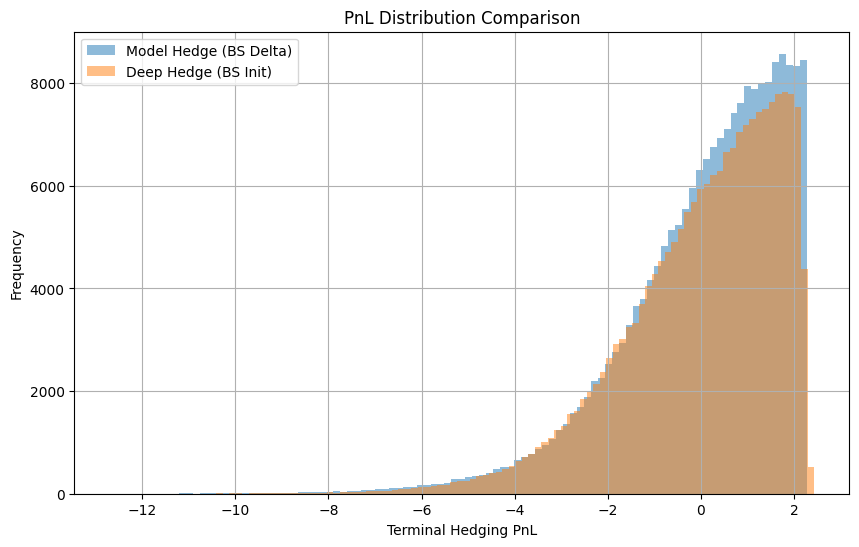

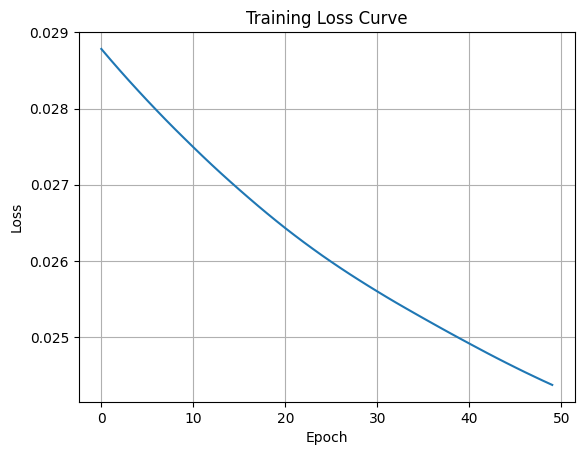

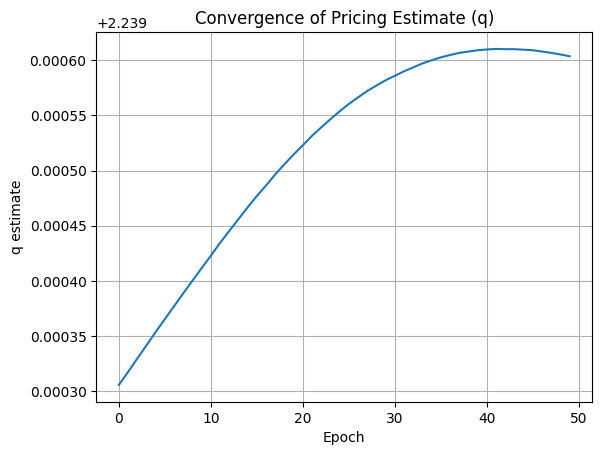

In [8]:
# ---------------------------------------------------------------------------
# 7) Visualisations
# ---------------------------------------------------------------------------
plt.figure(figsize=(10,6))
for name, res in results.items():
    plt.hist(res["pnl"], bins=100, alpha=0.5, label=name)
plt.title("PnL Distribution Comparison")
plt.xlabel("Terminal Hedging PnL")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

plt.plot(q_history)
plt.title("Convergence of Pricing Estimate (q)")
plt.xlabel("Epoch")
plt.ylabel("q estimate")
plt.grid(True)
plt.show()


In [21]:
def plot_side_by_side_hist(pnl1, pnl2, label1="Strategy A", label2="Strategy B",
                           bins=20, x_range=(-10, 10), title=None, save_path=None):
    """
    Plot side-by-side histograms for two PnL distributions with aligned bins.
    
    Args:
        pnl1, pnl2: numpy arrays of PnL values.
        label1, label2: labels for the two strategies.
        bins: number of histogram bins (default is 20 for wider bins).
        x_range: tuple, (min, max) for histogram x-axis.
        title: custom plot title. If None, generates one automatically.
        save_path: optional file path to save the plot.
    """
    counts1, edges = np.histogram(pnl1, bins=bins, range=x_range)
    counts2, _     = np.histogram(pnl2, bins=edges)

    centers = 0.5 * (edges[:-1] + edges[1:])
    width   = (edges[1] - edges[0]) / 3.0

    plt.figure(figsize=(10, 6))
    plt.bar(centers - width/2, counts1, width=width, alpha=0.6, label=label1, color='tab:blue')
    plt.bar(centers + width/2, counts2, width=width, alpha=0.6, label=label2, color='tab:orange')

    plt.xlabel("Terminal Hedging PnL", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.title(title or f"Side-by-side PnL Histogram: {label1} vs. {label2}")
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


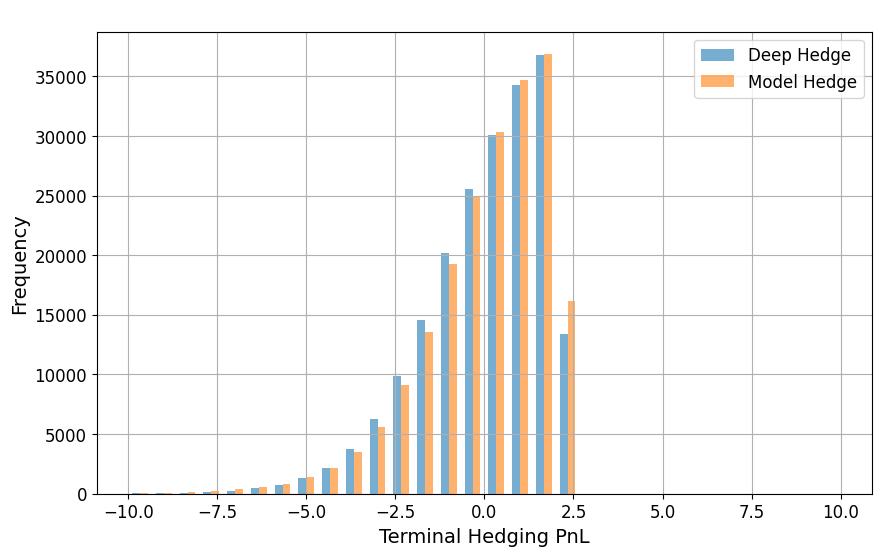

In [22]:
plot_side_by_side_hist(
    pnl1=pnl_rec_bs,
    pnl2=model_pnl,
    label1="Deep Hedge",
    label2="Model Hedge",
    bins=30,
    x_range=(-10, 10),
    title=" "
)


🔍 Pricing Comparison:

                        q (Learned)  p0 (Risk-Neutral)  Price Difference
Model Hedge (BS Delta)     2.287151           2.287151          0.000000
Deep Hedge (BS Init)       2.239602           2.287151         -0.047549


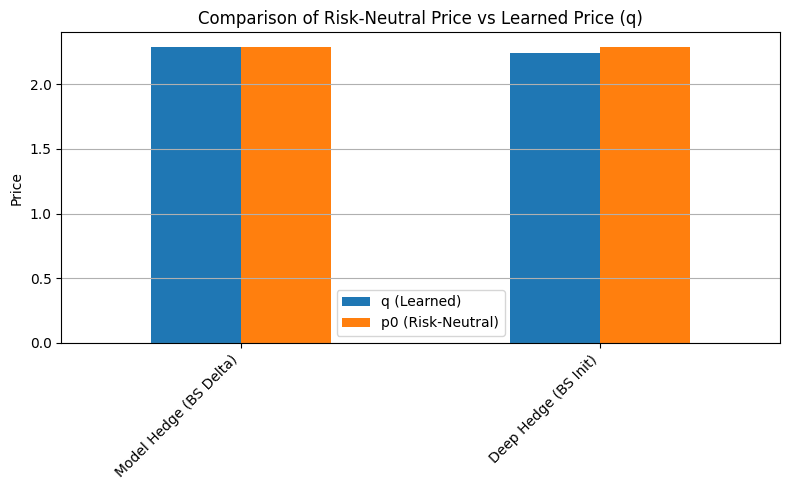

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Define p0 from Black-Scholes (risk-neutral price)
p0 = q_bs  # from your earlier BS calculation

# Gather prices from different strategies
price_comparison = {
    "Model Hedge (BS Delta)": q_bs,
    "Deep Hedge (BS Init)": q_rec_bs
}

# Convert to DataFrame
price_df = pd.DataFrame.from_dict(price_comparison, orient='index', columns=["q (Learned)"])
price_df["p0 (Risk-Neutral)"] = p0  # same across rows for comparison
price_df["Price Difference"] = price_df["q (Learned)"] - price_df["p0 (Risk-Neutral)"]

# Print table
print("\n🔍 Pricing Comparison:\n")
print(price_df)

# Plot
ax = price_df[["q (Learned)", "p0 (Risk-Neutral)"]].plot(kind="bar", figsize=(8, 5))
plt.title("Comparison of Risk-Neutral Price vs Learned Price (q)")
plt.ylabel("Price")
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
